## 1.

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.decomposition import PCA

In [225]:
# Reproducibility
seed = 0
np.random.seed(seed)

In [226]:
# Load the dataset
dataset = np.load("../dataset.npz")
X, y = dataset["X"], dataset["y"]

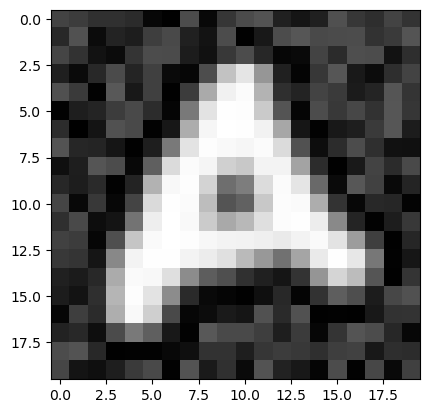

10


In [227]:
# Test of dataset, show first X with print of corresponding classification
plt.imshow(X[0].reshape(20,20), vmin=0, vmax=255, cmap="gray")
plt.show()
print(y[0])

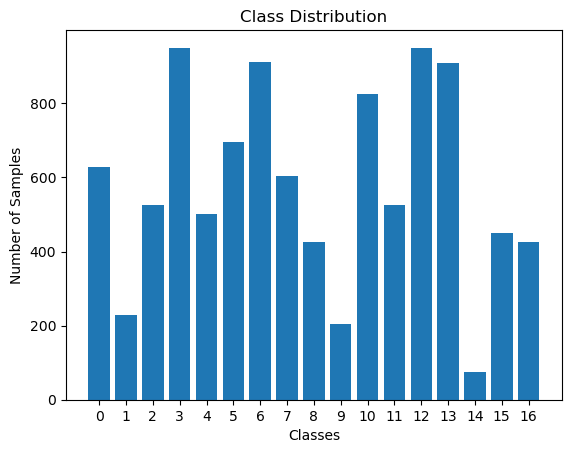

In [228]:
# Plot class distribution of the dataset (dataset.npz)
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(unique)
plt.show()

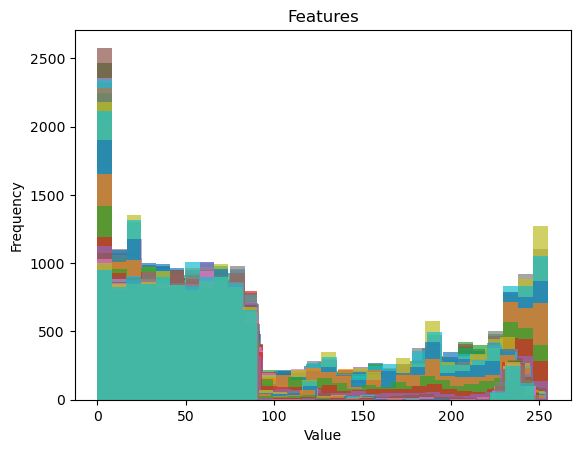

In [229]:
# Plot feature frequencies of the dataset (dataset.npz)
features = list(range(0, 400))

plt.figure()
for i in features:
    plt.hist(X[:, i], bins=30, alpha=0.7)

plt.title("Features")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [230]:
# Pre-processing
grayscale = 255.0
X = X / grayscale

# Split the data, 70% for training and 30% for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=seed)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

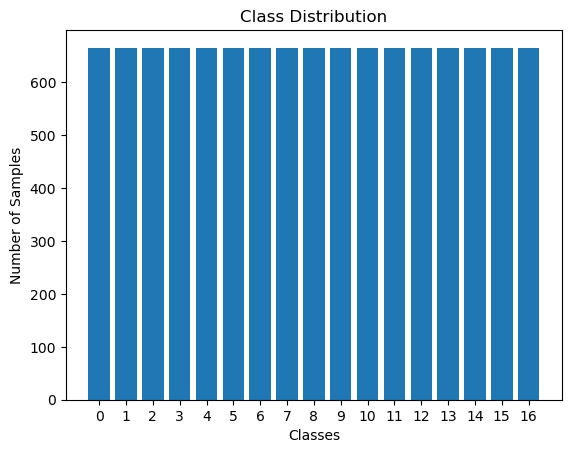

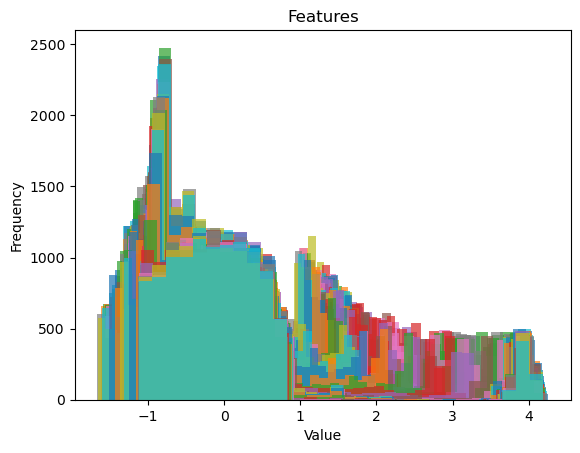

In [231]:
# Plot class distribution
unique, counts = np.unique(y_train_smote, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(unique)
plt.show()

# Plot feature frequencies
plt.figure()
for i in features:
    plt.hist(X_train_smote[:, i], bins=30, alpha=0.7)

plt.title("Features")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [232]:
# Initialize the CV to be 5 Folds
cross_validation = 5

# Support Vector Machine Classifier
svm_clf = SVC(random_state=seed)
svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
}
svm_clf_grid = GridSearchCV(svm_clf, svm_params, cv=cross_validation, scoring="accuracy", verbose=1)
svm_clf_grid.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(random_state=0),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=1)

In [233]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=seed)
rf_params = {
    "n_estimators": [10, 30],
    "max_depth": [10, 50],
    "criterion": ["gini", "entropy"],
    "max_features": ["sqrt", "log2", None],
}
rf_clf_grid = GridSearchCV(rf_clf, rf_params, cv=cross_validation, scoring="accuracy", verbose=1)
rf_clf_grid.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 50],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 30]},
             scoring='accuracy', verbose=1)

In [234]:
# Best parameters
print("Best parameters for SVM:", svm_clf_grid.best_params_)
print("Best parameters for Random Forest:", rf_clf_grid.best_params_)
print()

# Best accuracy
print("Best accuracy for SVM:", svm_clf_grid.best_score_)
print("Best accuracy for Random Forest:", rf_clf_grid.best_score_)

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 30}

Best accuracy for SVM: 0.9662980981866431
Best accuracy for Random Forest: 0.9297655904467049


In [235]:
# Choose the best model based on the highest cross-validation accuracy achieved for each model
if svm_clf_grid.best_score_ > rf_clf_grid.best_score_:
    # Evaluate the model on the test data
    y_pred_svm_clf = svm_clf_grid.best_estimator_.predict(X_test_scaled)
    f1_macro_svm_clf = f1_score(y_test, y_pred_svm_clf, average="macro")
    f1_weighted_svm_clf = f1_score(y_test, y_pred_svm_clf, average="weighted")
    best_model = "SVM"
    model_to_use = svm_clf_grid.best_estimator_
    best_model_f1_macro = f1_macro_svm_clf
    best_model_f1_weighted = f1_weighted_svm_clf
    best_params = svm_clf_grid.best_params_

    print("Test set F1 Score SVM (macro):", f1_macro_svm_clf)
    print("Test set F1 Score SVM (weighted):", f1_weighted_svm_clf)
    print()

    print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm_clf))
else:
    # Evaluate the model on the test data
    y_pred_rf_clf = rf_clf_grid.best_estimator_.predict(X_test_scaled)
    f1_macro_rf_clf = f1_score(y_test, y_pred_rf_clf, average="macro")
    f1_weighted_rf_clf = f1_score(y_test, y_pred_rf_clf, average="weighted")
    best_model = "Random Forest"
    model_to_use = rf_clf_grid.best_estimator_
    best_model_f1_macro = f1_macro_rf_clf
    best_model_f1_weighted = f1_weighted_rf_clf
    best_params = rf_clf_grid.best_params_

    print("Test set F1 Score RF (macro):", f1_macro_rf_clf)
    print("Test set F1 Score RF (weighted):", f1_weighted_rf_clf)
    print()

    print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf_clf))


# Output the result
print(f"Best model: {best_model}")
print(f"Best model F1 (macro): {best_model_f1_macro}")
print(f"Best model F1 (weighted): {best_model_f1_weighted}")
print(f"Best parameters for the best model: {best_params}")
print()

Test set F1 Score SVM (macro): 0.888533303881354
Test set F1 Score SVM (weighted): 0.9119598921495807

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.88       188
           1       0.87      0.97      0.92        69
           2       0.91      0.93      0.92       157
           3       0.93      0.96      0.94       285
           4       0.89      0.88      0.88       150
           5       0.91      0.93      0.92       209
           6       0.97      0.94      0.96       274
           7       0.91      0.94      0.93       182
           8       0.90      0.84      0.87       128
           9       0.96      0.82      0.88        61
          10       0.91      0.95      0.93       248
          11       0.89      0.78      0.84       158
          12       0.94      0.95      0.94       285
          13       0.88      0.93      0.91       273
          14       0.77      0.45      0.57        22
    

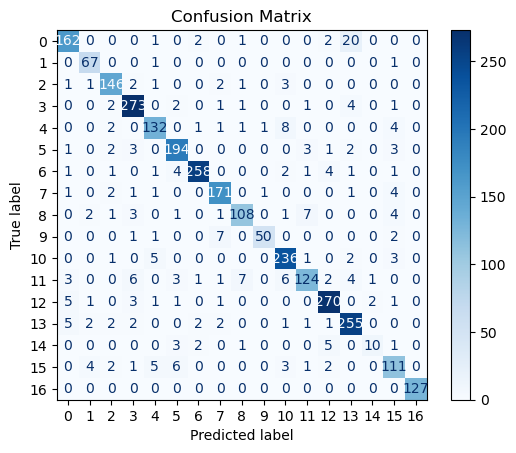

In [236]:
# Make predictions on the test data
y_pred = model_to_use.predict(X_test_scaled)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_to_use.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


## 2. Perform PCA dimensionality reduction

In [237]:
ks = [25, 50, 100, 150, 300]
results = {}
best_k = None
highest_accuracy = 0

for k in ks:
    pca = PCA(n_components=k, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_smote)
    X_test_pca = pca.transform(X_test_scaled)
    
    if best_model == "SVM":
        # Train SVM
        svm_clf_pca = GridSearchCV(SVC(random_state=seed), svm_params, cv=cross_validation, scoring="accuracy", verbose=1)
        
        # Time and fit the model
        start_time = time.time()
        svm_clf_pca.fit(X_train_pca, y_train_smote)
        end_time = time.time()

        best_accuracy = svm_clf_pca.best_score_

        results[k] = {
            "X_test_pca": X_test_pca,
            "best_estimator": svm_clf_pca.best_estimator_,
            "best_params": svm_clf_pca.best_params_,
            "best_accuracy": svm_clf_pca.best_score_,
            "time": end_time - start_time
        }

        print(f"Best parameters for SVM with n_components={k}:", svm_clf_pca.best_params_)
        print(f"Best accuracy for SVM with n_components={k}:", svm_clf_pca.best_score_)
        print()

        if best_accuracy > highest_accuracy:
            highest_accuracy = best_accuracy
            best_k = k
        
    elif best_model == "Random Forest":
        # Train Random Forest
        rf_clf_pca = GridSearchCV(RandomForestClassifier(random_state=seed), rf_params, cv=cross_validation, scoring="accuracy", verbose=1)

        # Time and fit the model
        start_time = time.time()
        rf_clf_pca.fit(X_train_pca, y_train_smote)
        end_time = time.time()

        best_accuracy = rf_clf_pca.best_score_

        results[k] = {
            "X_test_pca": X_test_pca,
            "best_estimator": rf_clf_pca.best_estimator_,
            "best_params": rf_clf_pca.best_params_,
            "best_accuracy": rf_clf_pca.best_score_,
            "time": end_time - start_time
        }

        print(f"Best parameters for Random Forest with n_components={k}:", rf_clf_pca.best_params_)
        print(f"Best accuracy for Random Forest with n_components={k}:", rf_clf_pca.best_score_)
        print()

        if best_accuracy > highest_accuracy:
            highest_accuracy = best_accuracy
            best_k = k

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM with n_components=25: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy for SVM with n_components=25: 0.9567448031844318

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM with n_components=50: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy for SVM with n_components=50: 0.9647943387881469

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM with n_components=100: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy for SVM with n_components=100: 0.9689517912428129

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM with n_components=150: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best accuracy for SVM with n_components=150: 0.9709862892525433

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM with n_components=300: {'C': 10, 'gamma': 'auto',

The best K is: 150
Test set F1 Score SVM PCA (macro): 0.8996412216100728
Test set F1 Score SVM PCA (weighted): 0.9201696564601234


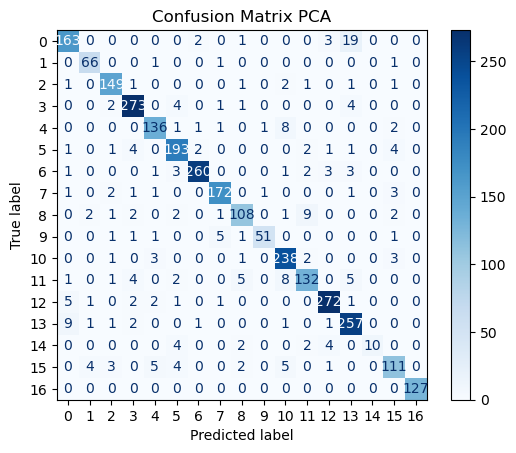

SVM PCA Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       188
           1       0.89      0.96      0.92        69
           2       0.92      0.95      0.93       157
           3       0.94      0.96      0.95       285
           4       0.91      0.91      0.91       150
           5       0.90      0.92      0.91       209
           6       0.98      0.95      0.96       274
           7       0.95      0.95      0.95       182
           8       0.89      0.84      0.86       128
           9       0.96      0.84      0.89        61
          10       0.90      0.96      0.93       248
          11       0.88      0.84      0.86       158
          12       0.95      0.95      0.95       285
          13       0.88      0.94      0.91       273
          14       1.00      0.45      0.62        22
          15       0.87      0.82      0.84       135
          16       1.00      1.00      1.00      

In [238]:
print("The best K is:", best_k)

# Make predictions on the test data, with the best PCA model (with accuracy in mind, e.i. not computation time)
best_pca_estimator = results[best_k]["best_estimator"]
best_pca_X_test_pca = results[best_k]["X_test_pca"]

# Evaluate
y_pred_pca_clf = best_pca_estimator.predict(best_pca_X_test_pca)
report = classification_report(y_test, y_pred_pca_clf)
f1_macro_svm_clf_pca = f1_score(y_test, y_pred_pca_clf, average="macro")
f1_weighted_svm_clf_pca = f1_score(y_test, y_pred_pca_clf, average="weighted")

print("Test set F1 Score SVM PCA (macro):", f1_macro_svm_clf_pca)
print("Test set F1 Score SVM PCA (weighted):", f1_weighted_svm_clf_pca)

# Create confusion matrix
cm_pca = confusion_matrix(y_test, y_pred_pca_clf)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_pca, display_labels=best_pca_estimator.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix PCA")
plt.show()

# Classification report of SVM PCA
print("SVM PCA Classification Report:\n", report)

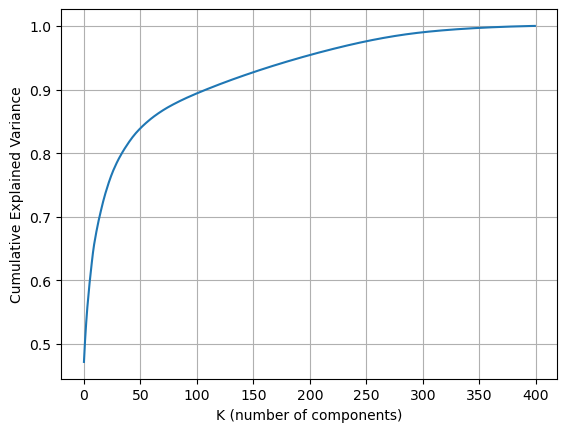

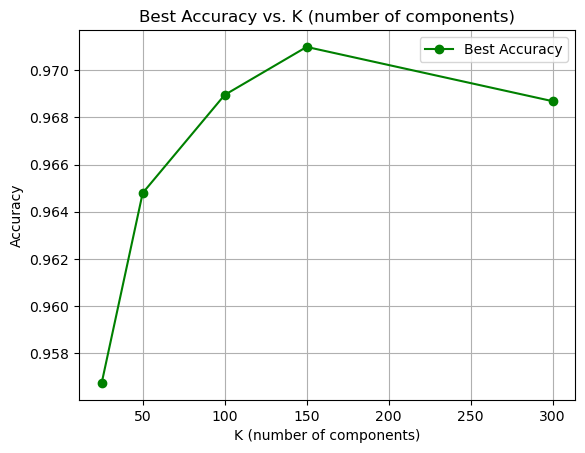

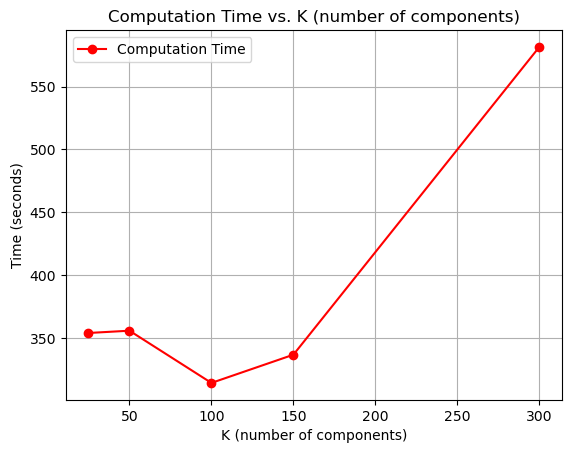

In [239]:
# Data for plotting
ks = list(results.keys())
best_accuracies = [results[k]["best_accuracy"] for k in ks]
times = [results[k]["time"] for k in ks]

# Plot of cumsum of explained varaince vs K (number of components)
pca = PCA(random_state=seed).fit(X_train_smote)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel("K (number of components)")
plt.ylabel("Cumulative Explained Variance")
plt.show()

# Plot Accuracy vs K (number of components)
plt.plot(ks, best_accuracies, marker="o", color="green", label="Best Accuracy")
plt.xlabel("K (number of components)")
plt.ylabel("Accuracy")
plt.title("Best Accuracy vs. K (number of components)")
plt.grid(True)
plt.legend()
plt.show()

# Plot Time vs K (number of components)
plt.plot(ks, times, marker="o", color="red", label="Computation Time")
plt.xlabel("K (number of components)")
plt.ylabel("Time (seconds)")
plt.title("Computation Time vs. K (number of components)")
plt.grid(True)
plt.legend()
plt.show()

## 3. Find OOD images

In [240]:
# Load the datasets
corrupt_dataset = np.load("../corrupt_dataset.npz")
X_corrupt = corrupt_dataset["X"]

dataset = np.load("../dataset.npz")
X, y = dataset["X"], dataset["y"]

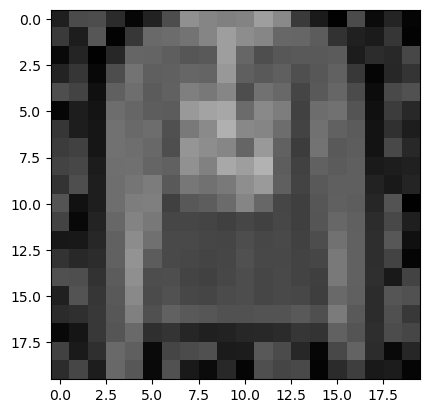

In [241]:
plt.imshow(X_corrupt[3].reshape(20,20), vmin=0, vmax=255, cmap="gray")
plt.show()

In [242]:
scaler = StandardScaler()
smote = SMOTE(random_state=seed)

# Pre-processing normal dataset
X_scaled = scaler.fit_transform(X)
X_smote, y_smote = smote.fit_resample(X_scaled, y)

# Pre-processing corrupt dataset
X_corrupt_scaled = scaler.transform(X_corrupt)

pca = PCA(n_components=best_k, random_state=seed)
X_pca = pca.fit_transform(X_smote)

corrupt_X_pca = pca.transform(X_corrupt_scaled)

In [243]:
# Function for plotting images for visualization if task is performed correctly
def plot_all_images(images, img_shape=(20, 20), cmap="gray"):
    images_per_row = 20
    num_images = len(images)
    num_rows = - (-num_images // images_per_row)

    # Set up figure
    _, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    # Plot every image
    for i, ax in enumerate(axes[:num_images]):
        ax.imshow(images[i].reshape(img_shape), vmin=0, vmax=255, cmap=cmap)
        ax.axis("off")
        ax.set_title(f"Image number: {i + 1}")
    
    # Hide unused subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


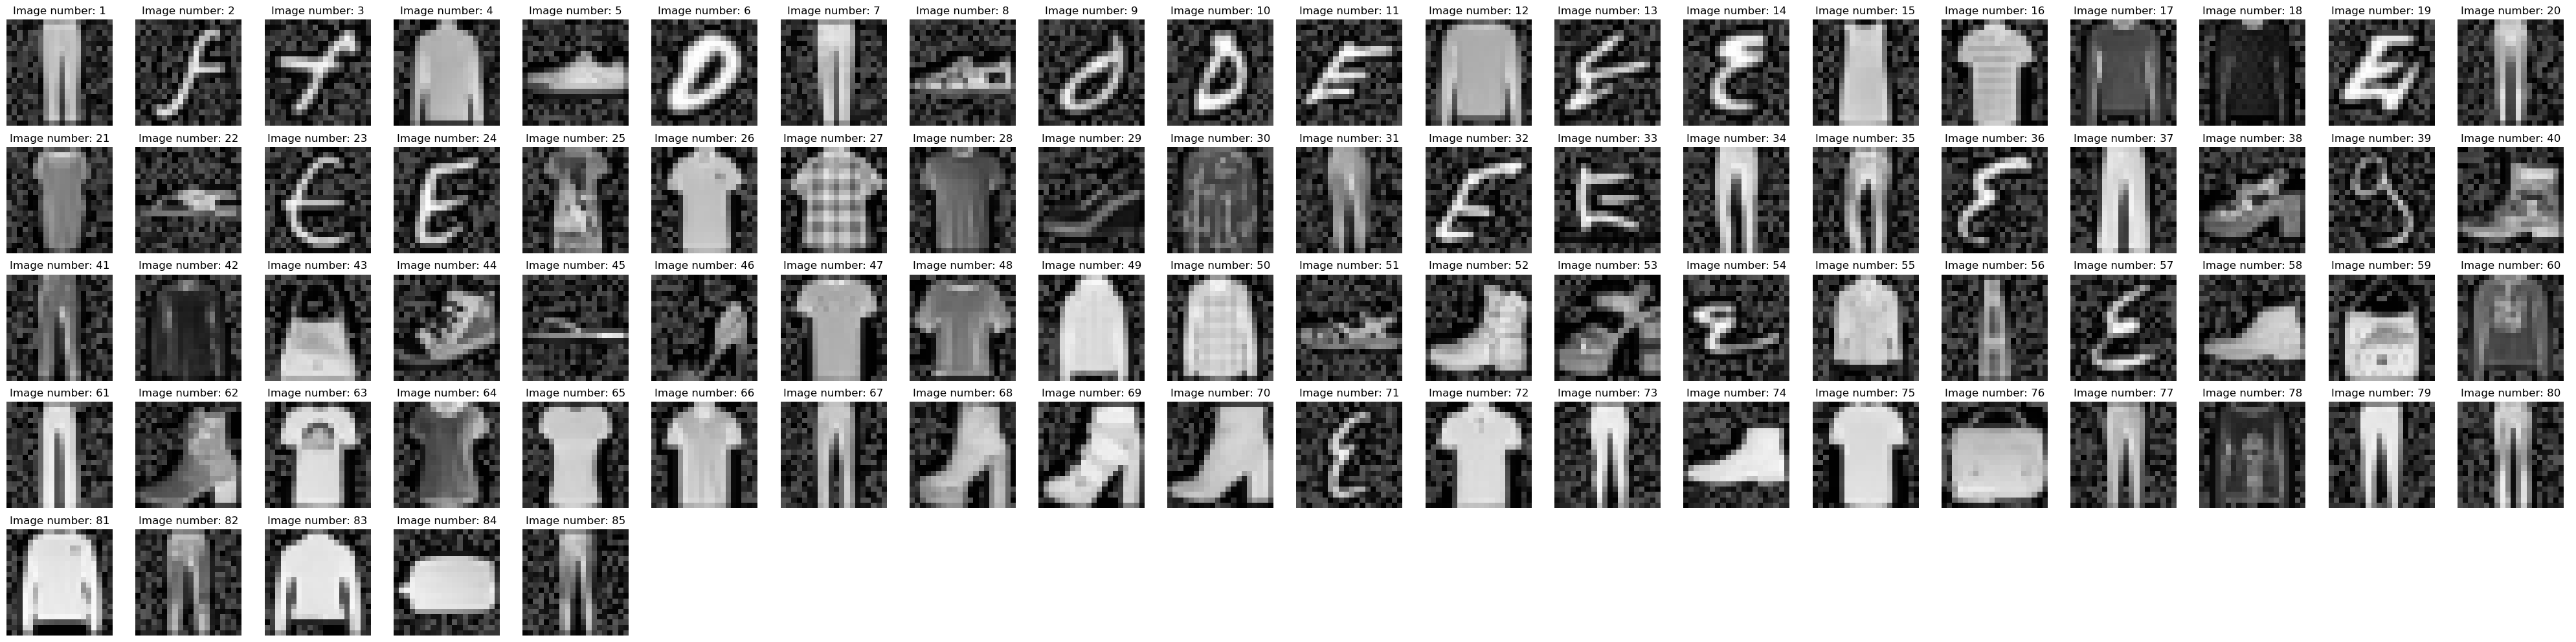

In [244]:
if best_model == "SVM":
    best_clf_pca = SVC(**best_params, probability=True, random_state=seed)
else:
    best_clf_pca = RandomForestClassifier(**best_params, probability=True, random_state=seed)

# Make predictions on the corrupt dataset using the best model
best_clf_pca.fit(X_pca, y_smote)
probabilities = best_clf_pca.predict_proba(corrupt_X_pca)

uncertainty_scores = 1 - np.max(probabilities, axis=1)
uncertainty_with_indices = list(enumerate(uncertainty_scores))
uncertanty_sorted = sorted(uncertainty_with_indices, key=lambda x: x[1])
indicies_sorted = [index for index, _ in uncertanty_sorted]
corrupted_images_sorted = X_corrupt[indicies_sorted]

# Plot to see if correct OOD is found
plot_all_images(corrupted_images_sorted[-85:])